In [32]:
from __future__ import print_function

import os
import sys
sys.path.append('/home/jogi/git/repository/smart_play_set')

import matplotlib.pyplot as plt
from matplotlib import rc

import numpy as np
from scipy import interp
from itertools import cycle

from utils.smart_utils import get_dir_path, tensor_to_pandas, load_hdf5_file
from utils.smart_utils import get_array_filenames, split_on_classes, create_row_mask
from utils.smart_utils import FuturoCube, calc_cos_sim, get_other_label
from preprocessing.process_data import get_data

from ReliefF import ReliefF
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_curve, auc

from sklearn.manifold import TSNE
from collections import OrderedDict

%matplotlib inline
%load_ext autoreload
%autoreload 2

PLOT_OUTPUT_DIR = '/home/jogi/git/repository/smart_play_set/plots/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
def get_features(mask, features):

    for i, f in enumerate(mask):
        print("%d. %s" % (i+1, features[f]))

        
def transform_x(X, features_idx):
    
    X_new = np.zeros((X.shape[0], len(features_idx)))
    for i, idx in enumerate(features_idx):
        X_new[:, i] = X[:, idx]
        
    return X_new


def prepare_data(option=330, two_class_opt='2_and_1'):
    
    if option == 330:
        x_train_all, y_labels_all, y_other_labels, dta_dict_f = get_data('20161206', force=False, 
                                                               apply_window_func=True, calc_mag=True,
                                                               extra_label="20hz_1axis_low8hz_330_12_True", 
                                                               optimal_w_size=False,
                                                               f_type='low', lowcut=8, b_order=5)

    elif option == 990:
        x_train_all, y_labels_all, y_other_labels, dta_dict_f = get_data('20161206', force=False, 
                                                               apply_window_func=True, calc_mag=True,
                                                               extra_label="20hz_1axis_low8hz_990_12_True", 
                                                               optimal_w_size=False,
                                                               f_type='low', lowcut=8, b_order=5)
    else:
        raise NotImplementedError("Error, %s as option is not implemented" % str(option))

    print(x_train_all.shape)
    print(y_labels_all.shape)
    features = dta_dict_f['features']

    y_labels_all = np.squeeze(y_labels_all)
    y_labels_2c = np.zeros(y_labels_all.shape[0])
    y_labels_2c[:] = y_labels_all[:]
    if two_class_opt == '2_and_1':
        # merge group 1 and 2
        y_labels_2c[y_labels_2c==2] = 1
        print(np.where(y_labels_2c==0)[0].shape)
        print(np.where(y_labels_2c==1)[0].shape)
    elif two_class_opt == 'only_0_1':
        pass
    elif two_class_opt == '0_and_1':
        # merge 1 with 0 group
        y_labels_2c[y_labels_2c==1] = 0
        y_labels_2c[y_labels_2c==2] = 1
        print(np.where(y_labels_2c==0)[0].shape)
        print(np.where(y_labels_2c==1)[0].shape)
        
    print("Unique labels y_labels_all ", np.unique(y_labels_all))
    print("Unique labels y_labels_2c ", np.unique(y_labels_2c))
    
    
    return x_train_all, y_labels_all, y_labels_2c, y_other_labels, features

x_train_all, y_labels_all, y_labels_2c, y_other_labels, features = prepare_data(330, two_class_opt='2_and_1')
y_label_id = get_other_label(y_other_labels, "ID")
y_label_perm = get_other_label(y_other_labels, "perm")
y_label_level = get_other_label(y_other_labels, "level")
print(features)

INFO - Used data label 20161206_futurocube_roadrunner_20hz_1axis_low8hz_330_12_True
INFO Loading matrices from h5 file /mnt/disk2/git/repository/smart_play_set/data/futurocube/roadrunner/20161206_futurocube_roadrunner_20hz_1axis_low8hz_330_12_True.h5
('INFO - List of arrays in this file: \n', [u'feature_data', u'label_data', u'label_game_level'])
INFO - Loading data description from json.
(330, 12)
(330, 1)
(210,)
(120,)
Unique labels y_labels_all  [0 1 2]
Unique labels y_labels_2c  [ 0.  1.]
[u'minf', u'maxf', u'mean', u'std', u'median', u'range', u'rms', u'mean_squared_jerk', u'dc', u'energy', u'power_spec_entropy', u'cos_sim']


Unique labels  [ 0.  1.]
--------------------------------------------------------------
Keep 1, top feature list: cos_sim
shape of x_train  (330, 1)
gnb - Accuracy: 0.624 (+/- 0.098)
svc - Accuracy: 0.627 (+/- 0.047)
--------------------------------------------------------------
Keep 2, top feature list: cos_sim, power_spec_entropy
shape of x_train  (330, 2)
gnb - Accuracy: 0.652 (+/- 0.201)
svc - Accuracy: 0.645 (+/- 0.172)
--------------------------------------------------------------
Keep 3, top feature list: cos_sim, power_spec_entropy, energy
shape of x_train  (330, 3)
gnb - Accuracy: 0.652 (+/- 0.161)
svc - Accuracy: 0.655 (+/- 0.188)
--------------------------------------------------------------
Keep 4, top feature list: cos_sim, power_spec_entropy, energy, dc
shape of x_train  (330, 4)
gnb - Accuracy: 0.642 (+/- 0.138)
svc - Accuracy: 0.667 (+/- 0.206)
--------------------------------------------------------------
Keep 5, top feature list: cos_sim, power_spec_entropy, energy, d

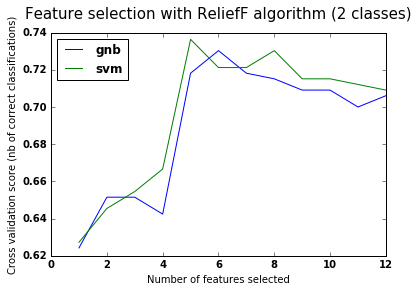

In [55]:
# y_labels = y_labels_all
y_labels = y_labels_2c[:]
# y_labels = y_label_level
print("Unique labels ", np.unique(y_labels))

rc('font', weight='bold')

num_of_features = len(features)
kept_feature_lists = []
res_gnb_mean = []
res_gnb_std = []
res_svc_mean = []
res_svc_std = []
num_of_classes = len(np.unique(y_labels))
num_of_samples = x_train_all.shape[0]
class_labels = "".join([str(int(i)) for i in np.unique(y_labels)])

for d in np.arange(1, num_of_features+1, 1):  # num_of_features+1
    idx = d
    fs = ReliefF(n_neighbors=10, n_features_to_keep=idx)
    x_train = fs.fit_transform(x_train_all, y_labels)
    f_list = [features[i] for i in fs.top_features]
    print("--------------------------------------------------------------")
    print("Keep %d, top feature list: %s" % (idx, ', '.join(f_list[:idx])))
    kept_feature_lists.append(', '.join(f_list[:idx]))
    
    gnb = GaussianNB()
    svc = SVC(kernel="rbf", C=0.75)
    linearSVC = LinearSVC(C=0.8, penalty="l2", dual=False, loss='squared_hinge')
    scores_gnb = []
    stddev_gnb = []
    scores_svc = []
    stddev_svc = []
    print("shape of x_train ", x_train.shape)
    for i in np.arange(50):
        scores = cross_val_score(gnb, x_train, y_labels, cv=StratifiedKFold(10), scoring='accuracy')
        scores_gnb.append(scores.mean())
        stddev_gnb.append(scores.std())
        scores = cross_val_score(OneVsRestClassifier(linearSVC), x_train, y_labels, cv=StratifiedKFold(10))
        scores_svc.append(scores.mean())
        stddev_svc.append(scores.std())
       
    res_gnb_mean.append(np.mean(np.array(scores_gnb)))
    res_gnb_std.append(np.mean(np.array(stddev_gnb)))
    res_svc_mean.append(np.mean(np.array(scores_svc)))
    res_svc_std.append(np.mean(np.array(stddev_svc)))
    print("gnb - Accuracy: %0.3f (+/- %0.3f)" % (res_gnb_mean[-1], res_gnb_std[-1] * 2))
    print("svc - Accuracy: %0.3f (+/- %0.3f)" % (res_svc_mean[-1], res_svc_std[-1] * 2))
    
    
# Plot number of features VS. cross-validation scores
plt.figure()
plt.title("Feature selection with ReliefF algorithm (%d classes)" % len(np.unique(y_labels)), fontsize=15, y=1.04)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(res_gnb_mean) + 1), res_gnb_mean, label="gnb")

plt.plot(range(1, len(res_svc_mean) + 1), res_svc_mean, label="svm")
plt.legend(loc="best")
outfile = PLOT_OUTPUT_DIR + 'feature_sel_reliefF_' + str(num_of_samples) + "_" + str(num_of_classes) + \
                                "_" + class_labels + 'classes.png'
print("Save to %s" % outfile)
plt.savefig(outfile, dpi=100)

print("gnb best features")
print(kept_feature_lists[np.argmax(res_gnb_mean)])
print("svc best features")
print(kept_feature_lists[np.argmax(res_svc_mean)])

[ 0.  1.]
--- Most predictive features SVM ---
1. std
2. mean_squared_jerk
3. power_spec_entropy

--- Most predictive features RandomForest ---
1. minf
2. maxf
3. std
4. range
5. rms
6. mean_squared_jerk
7. power_spec_entropy
Save to /home/jogi/git/repository/smart_play_set/plots/feature_sel_RFE_330_2_01classes.png
--- Final score with k-fold cross-validation
x_train_svc.shape  (330, 3)
x_train_rfc.shape  (330, 7)
svc - Accuracy: 0.75 (+/- 0.30)
rfc - Accuracy: 0.72 (+/- 0.28)


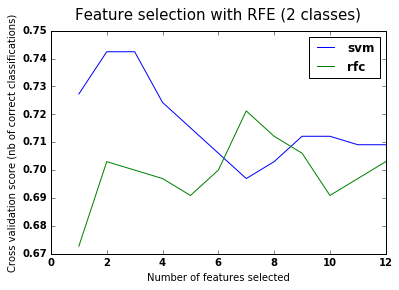

In [54]:
# y_labels = y_labels_all
y_labels = y_labels_2c[:]

print(np.unique(y_labels))

"""
    It operates by trying to choose the σ_0 features which lead to the largest margin of
    class separation, using an SVM classifier. This combinatorial
    problem is solved in a greedy fashion at each iteration of training by removing
    the input dimension that decreases the margin the least until only σ_0 input
    dimensions remain.
"""

# Create the RFE object and compute a cross-validated score.

linearSVC = LinearSVC(C=0.8, penalty="l2", dual=False, loss='squared_hinge')
rfc = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=2, min_samples_leaf=4)

# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv_res = np.zeros(x_train_all.shape[1])
opt_feature_num = []

for i in np.arange(1):
    rfecv_svc = RFECV(estimator=OneVsRestClassifier(linearSVC), step=1, cv=StratifiedKFold(10),
                  scoring='accuracy')
    x_train_svc = rfecv_svc.fit_transform(x_train_all, y_labels)
    print("--- Most predictive features SVM ---")
    get_features(np.where(np.array(rfecv_svc.ranking_)==1)[0], features)
    opt_feature_num.append(rfecv_svc.n_features_)
    
    print("")
    rfecv_rfc = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10),
                          scoring='accuracy')  # scoring='roc_auc', 'accuracy'
    x_train_rfc = rfecv_rfc.fit_transform(x_train_all, y_labels)
    print("--- Most predictive features RandomForest ---")
    get_features(np.where(np.array(rfecv_rfc.ranking_)==1)[0], features)
    
    opt_feature_num.append(rfecv_rfc.n_features_)
    
# Plot number of features VS. cross-validation scores
num_of_classes = len(np.unique(y_labels))
num_of_samples = x_train_all.shape[0]
class_labels = "".join([str(int(i)) for i in np.unique(y_labels)])

plt.figure()
plt.title("Feature selection with RFE (%d classes)" % num_of_classes, fontsize=15, y=1.03)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv_svc.grid_scores_) + 1), rfecv_svc.grid_scores_, label="svm")
plt.plot(range(1, len(rfecv_rfc.grid_scores_) + 1), rfecv_rfc.grid_scores_, label="rfc")
plt.legend(loc="best")
outfile = PLOT_OUTPUT_DIR + 'feature_sel_RFE_' + str(num_of_samples) + "_" + str(num_of_classes) + "_" + \
                             class_labels + 'classes.png'
print("Save to %s" % outfile)
plt.savefig(outfile, dpi=100)

print("--- Final score with k-fold cross-validation")
print("x_train_svc.shape ", x_train_svc.shape)
print("x_train_rfc.shape ", x_train_rfc.shape)
scores_svc = cross_val_score(OneVsRestClassifier(linearSVC), x_train_svc, y_labels, cv=StratifiedKFold(10),
                             scoring='accuracy')
print("svc - Accuracy: %0.2f (+/- %0.2f)" % (scores_svc.mean(), scores_svc.std() * 2))
scores_rfc = cross_val_score(rfc, x_train_rfc, y_labels, cv=StratifiedKFold(10), scoring='accuracy')
print("rfc - Accuracy: %0.2f (+/- %0.2f)" % (scores_rfc.mean(), scores_rfc.std() * 2))

In [58]:
scores_svc = cross_val_score(linearSVC, x_train_svc, y_labels, cv=StratifiedKFold(10),
                             scoring='accuracy')
print("svc - Accuracy: %0.2f (+/- %0.2f)" % (scores_svc.mean(), scores_svc.std() * 2))
scores_rfc = cross_val_score(rfc, x_train_rfc, y_labels, cv=StratifiedKFold(10), scoring='accuracy')
print("rfc - Accuracy: %0.2f (+/- %0.2f)" % (scores_rfc.mean(), scores_rfc.std() * 2))

print(rfecv_svc.grid_scores_)
print(rfecv_rfc.grid_scores_)

svc - Accuracy: 0.75 (+/- 0.30)
rfc - Accuracy: 0.72 (+/- 0.28)
[ 0.72727273  0.74242424  0.74242424  0.72424242  0.71515152  0.70606061
  0.6969697   0.7030303   0.71212121  0.71212121  0.70909091  0.70909091]
[ 0.67272727  0.7030303   0.7         0.6969697   0.69090909  0.7
  0.72121212  0.71212121  0.70606061  0.69090909  0.6969697   0.7030303 ]


--- Final score with k-fold cross-validation
svc - Accuracy: 0.82 (+/- 0.00)
gnb - Accuracy: 0.82 (+/- 0.05)
Save to /home/jogi/git/repository/smart_play_set/plots/30sec_2f_990_2classes-tsne_projection.png


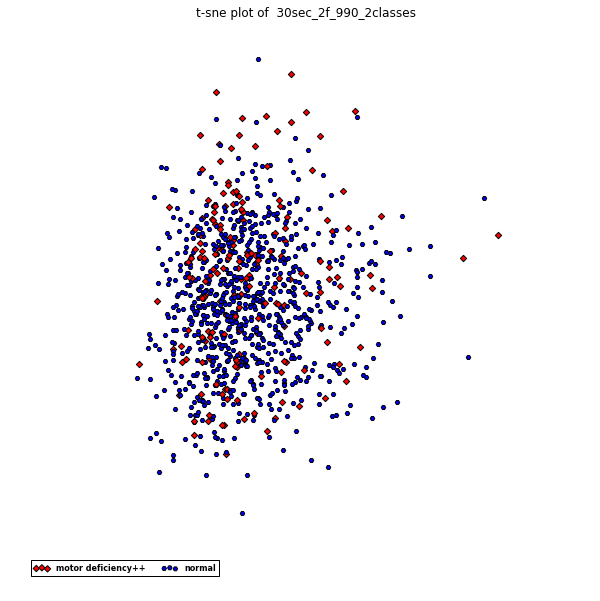

In [11]:
def visualize_2d(x_data, labels, logpath, prefix=None, width=10, height=10):
    
    labels = labels.astype(float)
    # colors = ['b', 'g', 'r', 'c', 'm', 'y', '#ff6666', '#66ff66', '#6666ff', '#666666']
    colors = ['b', 'y', 'r']
    # markers = ['x', '+', '^', 'D', '<', '>', '8', '*', 'H', 'o']
    markers = ['H', '8', 'D']
    legend_labels = ['normal', 'motor deficiency+', 'motor deficiency++']
    
    plot_data = np.append(x_data, np.expand_dims(labels, axis=1), axis=1)
    fig = plt.figure(figsize=(width, height))
    ax = fig.add_subplot(111)
    
    for x, y, c in plot_data.tolist():
        ax.scatter(x, y, c=colors[int(c)], marker=markers[int(c)], label=legend_labels[int(c)])

    # remove duplicates
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.axis('off')
    plt.title("t-sne plot of  " + prefix)
    plt.legend(by_label.values(), by_label.keys(), loc='lower left', numpoints=1, ncol=5, fontsize=8)
    outfile = logpath + prefix + '-tsne_projection.png'
    print("Save to %s" % outfile)
    plt.savefig(outfile)
    

def visualize_features(features, labels, logpath='/home/jogi/git/repository/smart_play_set/plots/', prefix=None,
                       width=10, height=10):

    labels = labels.astype(float)
    # colors = ['b', 'g', 'r', 'c', 'm', 'y', '#ff6666', '#66ff66', '#6666ff', '#666666']
    colors = ['b', 'y', 'r']
    # markers = ['x', '+', '^', 'D', '<', '>', '8', '*', 'H', 'o']
    markers = ['H', '8', 'D']
    legend_labels = ['normal', 'motor deficiency+', 'motor deficiency++']

    tsne = TSNE(n_components=2, random_state=0, learning_rate=1000)
    feature_projection = tsne.fit_transform(features)
    plot_data = np.append(feature_projection, np.expand_dims(labels, axis=1), axis=1)

    fig = plt.figure(figsize=(width, height))
    ax = fig.add_subplot(111)

    for x, y, c in plot_data.tolist():
        ax.scatter(x, y, c=colors[int(c)], marker=markers[int(c)], label=legend_labels[int(c)])

    # remove duplicates
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.axis('off')
    plt.title("2d plot of  " + prefix)
    plt.legend(by_label.values(), by_label.keys(), loc='lower left', numpoints=1, ncol=5, fontsize=8)
    outfile = logpath + prefix + '-tsne_projection.png'
    print("Save to %s" % outfile)
    plt.savefig(outfile)
    
#   0      1     2    3     4       5     6        7              8    9          10                11 
# [minf, maxf, mean, std, median, range, rms, mean_squared_jerk, dc, energy, power_spec_entropy, cos_sim]
# ReliefF: cos_sim, power_spec_entropy, energy, dc, mean_squared_jerk

# x_train = transform_x(x_train_all, [11, 10, 9, 8, 7])
# x_train = transform_x(x_train_all, [7, 10])
x_train = transform_x(x_train_all, [11, 10])


print("--- Final score with k-fold cross-validation")
scores_svc = cross_val_score(OneVsRestClassifier(linearSVC), x_train, y_labels, cv=StratifiedKFold(10))
print("svc - Accuracy: %0.2f (+/- %0.2f)" % (scores_svc.mean(), scores_svc.std() * 2))
scores_gnb = cross_val_score(gnb, x_train, y_labels, cv=StratifiedKFold(30))
print("gnb - Accuracy: %0.2f (+/- %0.2f)" % (scores_gnb.mean(), scores_gnb.std() * 2))

# visualize_features(x_train, y_labels, PLOT_OUTPUT_DIR, prefix="30sec_2f_990_2classes")

visualize_2d(x_train, y_labels, PLOT_OUTPUT_DIR, prefix="30sec_2f_990_2classes")

RandomForest  :  [0, 1, 3, 5, 6, 7, 9, 10, 11]
Save to /home/jogi/git/repository/smart_play_set/plots/t_test_rfc_9f_330_2c_roc_curve.png


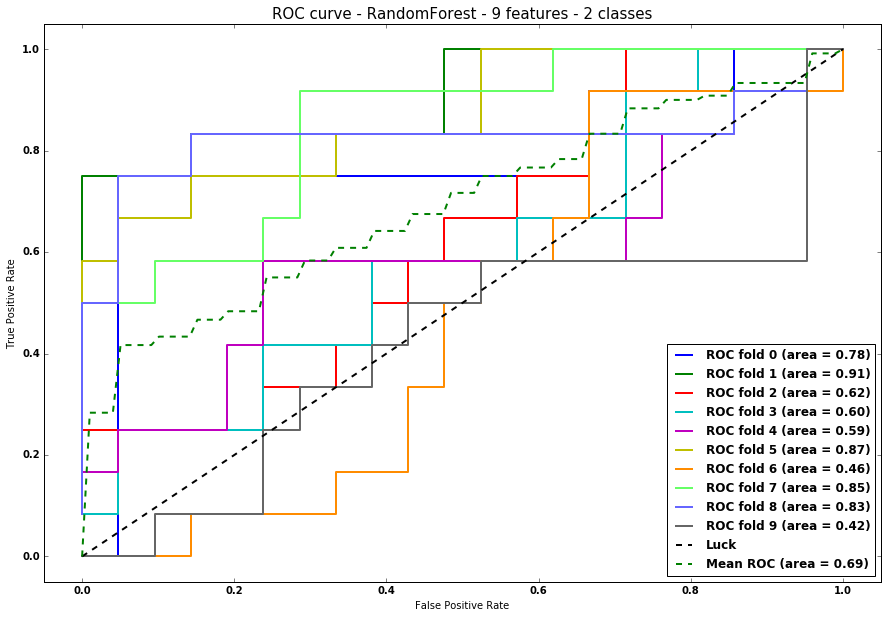

In [52]:

def plot_roc_auc(classifier, X, y_train, feature_idxs, p_title, logpath, prefix, k_fold=10):
    # Run classifier with cross-validation and plot ROC curves
    x_train = transform_x(X, feature_idxs)
    cv = StratifiedKFold(n_splits=k_fold)
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    colors = cycle(['b', 'g', 'r', 'c', 'm', 'y', 'darkorange', '#66ff66', '#6666ff', '#666666'])
    lw = 2

    i = 0
    fig = plt.figure(figsize=(15, 10))

    for (train, test), color in zip(cv.split(x_train, y_labels), colors):
        probas_ = classifier.fit(x_train[train], y_labels[train]).predict_proba(x_train[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_labels[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw, color=color,
                 label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
             label='Luck')

    mean_tpr /= cv.get_n_splits(x_train, y_labels)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(p_title, fontsize=15)
    plt.legend(loc="lower right")
    outfile = logpath + prefix + '_roc_curve.png'
    print("Save to %s" % outfile)
    plt.savefig(outfile)

y_labels = y_labels_2c[:]
#   0      1     2    3     4       5     6        7              8    9          10                11 
# [minf, maxf, mean, std, median, range, rms, mean_squared_jerk, dc, energy, power_spec_entropy, cos_sim]
feature_set_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
one_feature = [11]
feature_set_svm1 = [7, 8, 9, 10, 11]
feature_set_svm2 = [7, 10]
# 1. minf 2. maxf 3. mean 4. std 5. range 6. mean_squared_jerk 7. energy 8. power_spec_entropy
feature_set_rfc = [0, 1, 2, 3, 5, 7, 9, 10]

feature_set_t_test = [0, 1, 3, 5, 6, 7, 9, 10, 11]

classifiers = {"rfc": "RandomForest", "gnb": "Naive Bayes", "svm": "SVM"}
clf_id = "rfc"
feature_set = feature_set_t_test

num_of_classes = len(np.unique(y_labels))
num_of_samples = x_train_all.shape[0]
prefix = "t_test_" + clf_id + "_" + str(len(feature_set)) + "f_" + str(num_of_samples) + "_2c" 

if clf_id == "rfc":
    print(classifiers[clf_id], " : ", feature_set)
    clf = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=2, min_samples_leaf=4)
elif clf_id == "gnb":
    print(classifiers[clf_id])
    clf = GaussianNB()
elif clf_id == "svm":
    print(classifiers[clf_id])
    clf = SVC(kernel="rbf", C=0.75, probability=True)
else:
    raise NotImplementedError("Unknown classifier")
    
p_title = "ROC curve - %s - %d features - 2 classes" % (classifiers[clf_id], len(feature_set))
plot_roc_auc(clf, x_train_all, y_labels, feature_set, p_title, PLOT_OUTPUT_DIR, prefix)

In [51]:
import scipy.stats as stats
"""
    (1) Two-Sample T-Test
        
"""


def compute_t_test(X, y, feature_idxs, features, class_labels=[0,1]):
    
    # assuming binary classes
    normal = y == class_labels[0]
    positive = y == class_labels[1]
    print("Normal/Positive ", np.count_nonzero(normal), np.count_nonzero(positive))
    
    for f in feature_idxs:
        n_group = X[normal, f]
        p_group = X[positive, f]

        t_value, p_value = stats.ttest_ind(a=n_group, b=p_group, equal_var=False)    
        print("Feature %s: t_value %.4f, p_value %.4f, mean-normal %.3f, mean-positive %.3f" % 
             (features[f], t_value, p_value, np.mean(n_group), np.mean(p_group)))

y_labels = y_labels_2c[:]
compute_t_test(x_train_all, y_labels, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], features)

Normal/Positive  210 120
Feature minf: t_value 2.0555, p_value 0.0408, mean-normal 0.082, mean-positive -0.143
Feature maxf: t_value -4.6911, p_value 0.0000, mean-normal -0.198, mean-positive 0.347
Feature mean: t_value -1.6031, p_value 0.1103, mean-normal -0.068, mean-positive 0.119
Feature std: t_value -4.1096, p_value 0.0001, mean-normal -0.169, mean-positive 0.296
Feature median: t_value 0.0034, p_value 0.9973, mean-normal 0.000, mean-positive -0.000
Feature range: t_value -4.8673, p_value 0.0000, mean-normal -0.205, mean-positive 0.359
Feature rms: t_value -2.4713, p_value 0.0142, mean-normal -0.104, mean-positive 0.182
Feature mean_squared_jerk: t_value -7.2534, p_value 0.0000, mean-normal -0.318, mean-positive 0.556
Feature dc: t_value -1.1916, p_value 0.2346, mean-normal -0.050, mean-positive 0.087
Feature energy: t_value -1.9073, p_value 0.0576, mean-normal -0.077, mean-positive 0.136
Feature power_spec_entropy: t_value -4.0204, p_value 0.0001, mean-normal -0.170, mean-positiv

In [ ]:
one_feature = [11]
feature_set_svm1 = [7, 8, 9, 10, 11]
feature_set_svm2 = [7, 10]
# 1. minf 2. maxf 3. mean 4. std 5. range 6. mean_squared_jerk 7. energy 8. power_spec_entropy
feature_set_rfc = [0, 1, 2, 3, 5, 7, 9, 10]

linearSVC = LinearSVC(C=0.8, penalty="l2", dual=False, loss='squared_hinge')
rfc = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=2, min_samples_leaf=4)
gnb = GaussianNB()

x_train = transform_x(x_train_all, feature_set_svm1)
y_true = y_labels_2c[:]

linearSVC.fit(x_train, y_true)
y_pred = linearSVC.predict(x_train)


Confusion matrix, without normalization
[[203   7]
 [ 27  93]]


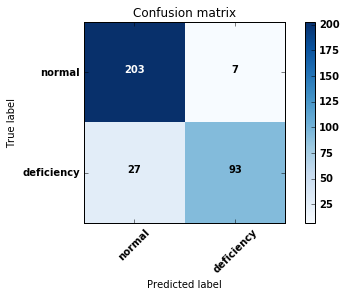

In [53]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

linearSVC = LinearSVC(C=0.8, penalty="l2", dual=False, loss='squared_hinge')
rfc = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=2, min_samples_leaf=4)
gnb = GaussianNB()


x_train = transform_x(x_train_all, feature_set_t_test)
y_true = y_labels_2c[:]

rfc.fit(x_train, y_true)
y_pred = rfc.predict(x_train)

c_matrix = confusion_matrix(y_true, y_pred)
plt.figure()
plot_confusion_matrix(c_matrix, classes=["normal", "deficiency"], title='Confusion matrix')
plt.show()

In [ ]:
rfc = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=2, min_samples_leaf=4)
rfecv_svc = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10),
                  scoring='accuracy')
x_train_svc = rfecv_svc.fit_transform(x_train_all, y_labels)
print("--- Most predictive features SVM ---")